# GPU Performance Test: H2O - XGBoost on GPU

![GPU vs CPU](https://s18.postimg.org/ataodekvt/GPU_vs_CPU.jpg)

## 1. Import the H2O Library and its XGBoost Estimator

In [1]:
import h2o
from h2o.estimators.xgboost import H2OXGBoostEstimator

## 2. Connect to a Running H2O instance or start a new one

In [4]:
%%capture
h2o.connect(ip="35.227.47.29")
h2o.no_progress()

## 3. Load Some Data From an Amazon S3 Bucket

In [6]:
# Import some data from Amazon S3
h2oDF = h2o.import_file(path="https://s3-us-west-1.amazonaws.com/dsclouddata/LendingClubData/LoansGoodBad.csv")


# Stratified Split into Train/Test
stratsplit = h2oDF["Bad_Loan"].stratified_split(test_frac=0.3, seed=12349453)
train = h2oDF[stratsplit=="train"]
test = h2oDF[stratsplit=="test"]


## 4. Specify the Response Column

In [7]:
# Identify predictors and response
x = train.columns
y = "Bad_Loan"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
train.head(5)

RowID,Loan_Amount,Term,Interest_Rate,Employment_Years,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
2,2500,60 months,15.27,0.5,RENT,30000,VERIFIED - income source,car,GA,1,0,9.4,4,BAD,12
3,2400,36 months,15.96,10,RENT,12252,not verified,small_business,IL,8.72,0,98.5,10,GOOD,10
4,10000,36 months,13.49,10,RENT,49200,VERIFIED - income source,other,CA,20,0,21,37,GOOD,15
5,5000,36 months,7.9,3,RENT,36000,VERIFIED - income source,wedding,AZ,11.2,0,28.3,12,GOOD,7
6,3000,36 months,18.64,9,RENT,48000,VERIFIED - income source,car,CA,5.35,0,87.5,4,GOOD,4


## 5. Train an XGBoost Model using GPU

In [10]:
%%time
XGB_GPU = H2OXGBoostEstimator(model_id="XGB_on_GPU", ntrees=50, max_depth=9, learn_rate=0.05, backend="gpu", gpu_id=0)
XGB_GPU.train(x=x, y=y, training_frame=train, validation_frame=test)
print "Accuracy AUC: " + str(XGB_GPU.auc())

Accuracy AUC: 0.715394061873
CPU times: user 145 ms, sys: 7.64 ms, total: 153 ms
Wall time: 31.8 s


## 6. Train an XGBoost Model using CPU

In [11]:
%%time
XGB_CPU = H2OXGBoostEstimator(model_id="XGB_on_CPU", ntrees=50, max_depth=9, learn_rate=0.05, backend="cpu")
XGB_CPU.train(x=x, y=y, training_frame=train, validation_frame=test)
print "Accuracy AUC: " + str(XGB_CPU.auc())

Accuracy AUC: 0.791112023776
CPU times: user 129 ms, sys: 12.1 ms, total: 141 ms
Wall time: 33.9 s


## 7. Which Option is Faster? Which Option Costs Less?

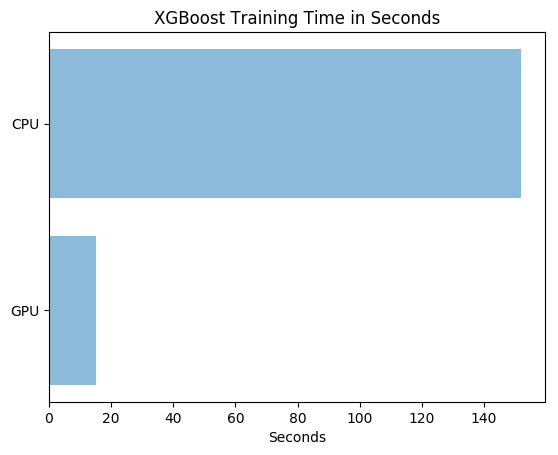

In [14]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('GPU', 'CPU')
y_pos = np.arange(len(objects))
seconds = [15,152]
 
plt.barh(y_pos, seconds, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Seconds')
plt.title('XGBoost Training Time in Seconds')
 
plt.show()

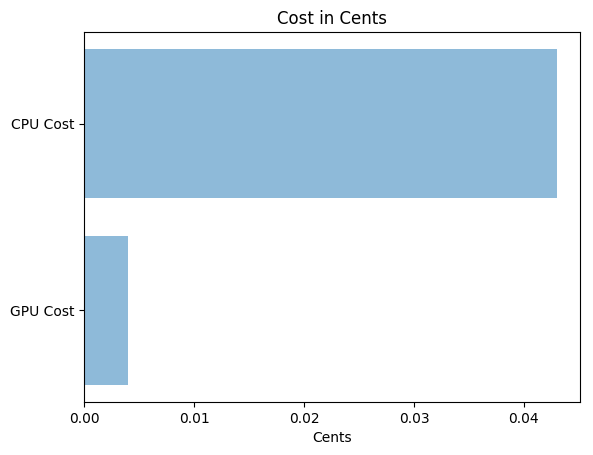

In [15]:
GPU_Cost = (0.9 / 3600) * 16
CPU_Cost = (0.7 / 3600) * 221
objects = ('GPU Cost', 'CPU Cost')
y_pos = np.arange(len(objects))
seconds = [GPU_Cost,CPU_Cost]
 
plt.barh(y_pos, seconds, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Cents')
plt.title('Cost in Cents')
 
plt.show()